# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from api import Benchmark

In [2]:
bench_dir = "cached/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [3]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [4]:
# Config
print("Config example:", train_data[0]["config"])

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


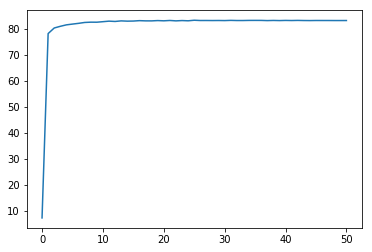

In [5]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

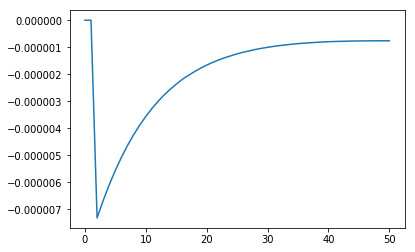

In [6]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [7]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [8]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [9]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523
